<strong> Import all libraires that will be used </strong>

In [1]:
from utils import PaintingsDataset, AttentionUNetDiscriminator, AttentionUNetGenerator, unet_d_criterion_without_cutmix
import os
import random
import torch
from torch.utils.data import DataLoader
from torchmetrics.image.fid import FrechetInceptionDistance
import torch.optim as optim
from torchvision import transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time

<strong> Initializing the paintings dataset </strong>

In [2]:
# Building the dataset
image_dir = '../../data/anime/images'

f = os.listdir(image_dir)[0]
print(f)
print(os.path.isfile(os.path.join(image_dir, f)))

# Transformations to normalize the data before dataloader
transform = transforms.Compose([
    transforms.Resize((64,64)), # Standardizing the size of the images
    transforms.ToTensor(), # Transforming to tensor
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)) # Normalizing
])


# Initializing the dataset
paintings = PaintingsDataset(image_dir, transform, limit=5000)
print(f"Dataset contains {len(paintings)} images")

0_2000.jpg
True
Dataset contains 5000 images


<strong> Sampling an element from the dataset and plotting it </strong>

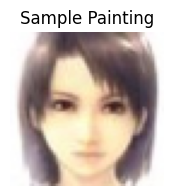

In [3]:
# Sampling randomly an element from the dataset
n = len(paintings)
integer = random.randint(0,n)

# Sampled image
image = paintings[integer].numpy()*0.5 + 0.5 # De-normalizing the image

# Plot the image
plt.figure(figsize=(3, 2))
plt.imshow(np.transpose(image, (1, 2, 0)))  
plt.axis('off')  # Hide axes
plt.title('Sample Painting')
plt.show()

<strong> Intializing the Dataloader </strong>

In [4]:
dataloader = DataLoader(paintings, batch_size=32)

<strong> Initializing the parameters of the model </strong>

In [5]:
# Model's parameters
latent_dim = 100
channels_out = 3
channels_in = 3

# Intializing the models
G = AttentionUNetGenerator(latent_dim, channels_out)
D = AttentionUNetDiscriminator(3)

<strong> Sampling a vector to plot the fake image generated by the Generator </strong>

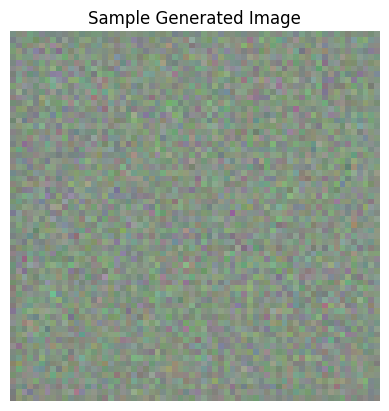

In [6]:
# Generate random noise
latent_dim = 100  # Latent space dimension

# Generate random noise
noise = torch.randn(16, latent_dim, 64, 64)  # Noise input for generator
# Generate images
fake_images = G(noise)  # Output shape: [16, 3, 128, 128]

# De-normalize and reshape the first generated image
image_generated = fake_images[0].detach().cpu().numpy()  # Select first image in batch
image_generated = image_generated * 0.5 + 0.5  # De-normalize to [0, 1]

# Plot the image
plt.imshow(np.transpose(image_generated, (1, 2, 0)))  # Convert to (H, W, C)
plt.axis('off')  # Hide axes
plt.title('Sample Generated Image')
plt.show()

<strong> Let build the training loop</strong>

In [7]:
torch.autograd.set_detect_anomaly(True)

experiment = 1

output_dir = f"training_samples/experiment_{experiment}"
os.makedirs(output_dir, exist_ok=True)

# Parameters
input_channels = 3
channels_out = input_channels
n_classes = 2
k = 1  # Steps to train generator
latent_dim = 128
epochs = 300  # Total number of epochs
lambda_gp = 10  # Gradient penalty weight

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Initialize models (Use Attention U-Net GAN models)
G_attention = AttentionUNetGenerator(latent_dim, channels_out).to(device)  # Latent space maps to input
D_attention = AttentionUNetDiscriminator(input_channels, features=64).to(device)  # PatchGAN discriminator

# Loss function and optimizers
criterion = torch.nn.BCELoss()  # Binary Cross-Entropy for GANs
optimizer_g = optim.Adam(G_attention.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_d = optim.Adam(D_attention.parameters(), lr=1e-4, betas=(0.5, 0.999))

# FID Evaluation setup
epoch_eval = 10  # Evaluate FID every `epoch_eval` epochs
fid = FrechetInceptionDistance(feature=192, reset_real_features=False, normalize=True)
n_samples = 500

# Ensure your dataset of real paintings is available
N = len(paintings)  # Assuming `paintings` is a tensor of real images
indices = random.sample(range(N), n_samples)
real_images_eval = torch.stack([paintings[idx] for idx in indices])
fid.update(real_images_eval, real=True)

# Track losses and FID values
FID_values = []
D_loss = []
G_loss = []

for epoch in tqdm(range(epochs)):
    start_time = time.time()

    for batch in tqdm(dataloader):
        # Get real images
        real_images = batch.to(device)
        batch_size = real_images.size(0)

        # Labels for real and fake images
        labels_real = torch.full((batch_size, 1), 0.9, device=device)
        labels_fake = torch.full((batch_size, 1), 0.1, device=device)

        ### Train Discriminator ###
        D_attention.zero_grad()
        
        # Real images
        real_images = real_images + torch.randn_like(real_images) * 0.01
        output_real = D_attention(real_images).view(-1, 1)
        loss_d_real = criterion(output_real, labels_real)

        # Fake images
        noise = torch.randn(batch_size, latent_dim, 64, 64, device=device)
        fake_images = G_attention(noise)
        fake_images = fake_images + torch.randn_like(fake_images) * 0.01
        
        output_fake = D_attention(fake_images.detach()).view(-1, 1)
        loss_d_fake = criterion(output_fake, labels_fake)
        
        alpha = torch.rand(batch_size, 1, 1, 1, device=device)  # Random weight for interpolation
        interpolates = alpha * real_images + (1 - alpha) * fake_images.detach()
        interpolates.requires_grad_(True)  # Enable gradients for interpolated images

        d_out_interpolates = D_attention(interpolates).view(-1, 1)
        gradients = torch.autograd.grad(
            outputs=d_out_interpolates,
            inputs=interpolates,
            grad_outputs=torch.ones_like(d_out_interpolates),
            create_graph=True,
            retain_graph=True,
        )[0]  # Get gradients of interpolated images

        # Compute gradient penalty
        gradients_norm = gradients.norm(2, dim=1)
        gradient_penalty = ((gradients_norm - 1) ** 2).mean()
        

        # Combine losses
        loss_d = loss_d_real + loss_d_fake + lambda_gp * gradient_penalty
        loss_d.backward()
        optimizer_d.step()

        ### Train Generator ###
        if epoch % k == 0:  # Train generator every `k` steps
            G_attention.zero_grad()
            output_fake_for_gen = D_attention(fake_images).view(-1, 1)
            loss_g = criterion(output_fake_for_gen, labels_real)  # Generator tries to make fake images appear real
            loss_g.backward()
            optimizer_g.step()
            
            # Track losses
            D_loss.append(loss_d.item())
            G_loss.append(loss_g.item())
    
    # Evaluate FID every `epoch_eval` epochs
    if epoch % epoch_eval == 0:
        G_attention.eval()  # Set generator to eval mode for FID computation
        
        # Generate evaluation images
        noise_eval = torch.randn(n_samples, latent_dim, 64, 64, device=device)
        fake_images_eval = G_attention(noise_eval).to(torch.device('cpu'))
        fid.update(fake_images_eval, real=False)
        fid_value = fid.compute().item()
        FID_values.append(fid_value)

        print(f'FID after epoch {epoch}: {fid_value}')

        # Save a grid of generated samples
        grid = vutils.make_grid(fake_images_eval[:16], normalize=True, scale_each=True)
        sample_path = os.path.join(output_dir, f"epoch_{epoch:03d}.png")
        vutils.save_image(grid, sample_path)
        print(f"Sample images saved to {sample_path}")

        fid.reset()
        G_attention.train()

    end_time = time.time()
    print(f'Epoch [{epoch + 1}/{epochs}] | Loss D: {loss_d.item()} | Loss G: {loss_g.item()}')
    print(f'Epoch duration: {end_time - start_time:.2f}s')


cuda


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

FID after epoch 0: 123.1484375
Sample images saved to training_samples/experiment_1\epoch_000.png
Epoch [1/300] | Loss D: 10.904486656188965 | Loss G: 2.2421603202819824
Epoch duration: 68.51s


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [2/300] | Loss D: 10.716025352478027 | Loss G: 2.646022081375122
Epoch duration: 66.27s


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [3/300] | Loss D: 10.633509635925293 | Loss G: 2.3531594276428223
Epoch duration: 66.53s


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [4/300] | Loss D: 10.752079963684082 | Loss G: 4.0293192863464355
Epoch duration: 65.83s


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [5/300] | Loss D: 10.740524291992188 | Loss G: 2.703451633453369
Epoch duration: 64.87s


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [6/300] | Loss D: 10.778977394104004 | Loss G: 1.4350519180297852
Epoch duration: 65.39s


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [7/300] | Loss D: 10.566923141479492 | Loss G: 1.1144843101501465
Epoch duration: 68.86s


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [8/300] | Loss D: 10.72619915008545 | Loss G: 1.9787445068359375
Epoch duration: 68.97s


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [9/300] | Loss D: 10.506261825561523 | Loss G: 1.6873478889465332
Epoch duration: 67.27s


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [10/300] | Loss D: 10.464942932128906 | Loss G: 2.495844602584839
Epoch duration: 67.69s


  0%|          | 0/157 [00:00<?, ?it/s]

FID after epoch 10: 104.30659484863281
Sample images saved to training_samples/experiment_1\epoch_010.png
Epoch [11/300] | Loss D: 10.661702156066895 | Loss G: 2.6344189643859863
Epoch duration: 68.55s


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [12/300] | Loss D: 10.502436637878418 | Loss G: 2.717317819595337
Epoch duration: 64.81s


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [13/300] | Loss D: 10.298008918762207 | Loss G: 2.6530070304870605
Epoch duration: 66.33s


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [14/300] | Loss D: 10.782960891723633 | Loss G: 4.305147647857666
Epoch duration: 66.83s


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [15/300] | Loss D: 10.504487991333008 | Loss G: 2.4365954399108887
Epoch duration: 67.74s


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [16/300] | Loss D: 10.69003677368164 | Loss G: 2.6465377807617188
Epoch duration: 68.45s


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [17/300] | Loss D: 10.588033676147461 | Loss G: 2.504314422607422
Epoch duration: 67.20s


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [18/300] | Loss D: 10.541845321655273 | Loss G: 3.2018723487854004
Epoch duration: 66.83s


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [19/300] | Loss D: 10.446083068847656 | Loss G: 2.97442889213562
Epoch duration: 65.50s


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [20/300] | Loss D: 10.324604988098145 | Loss G: 1.6708354949951172
Epoch duration: 66.59s


  0%|          | 0/157 [00:00<?, ?it/s]

FID after epoch 20: 99.32007598876953
Sample images saved to training_samples/experiment_1\epoch_020.png
Epoch [21/300] | Loss D: 10.607229232788086 | Loss G: 4.3569488525390625
Epoch duration: 68.24s


  0%|          | 0/157 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [8]:
torch.save(D_attention.state_dict(), f"weights/d_att_{experiment}.pth")
torch.save(G_attention.state_dict(), f"weights/g_att_{experiment}.pth")

<strong> Generating some examples using the trained generator </strong>

torch.Size([1, 3, 64, 64])


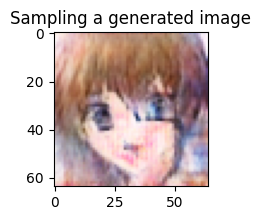

In [ ]:
# Generate random noise
noise = torch.randn(1, latent_dim, 64, 64)  # Batch of 16 noise vectors

G_unet_test = G_attention.to('cpu')
# Generate images
fake_images = G_unet_test(noise)

print(fake_images.size())  # Should be (16, img_channels, height, width)

image_noise = fake_images.detach().numpy().reshape((3,64,64))*0.5 + 0.5

plt.figure(figsize=(3, 2))
plt.imshow(np.transpose(image_noise, (1, 2, 0)))
plt.title("Sampling a generated image")
plt.show()

<strong> Plotting Losses <strong>

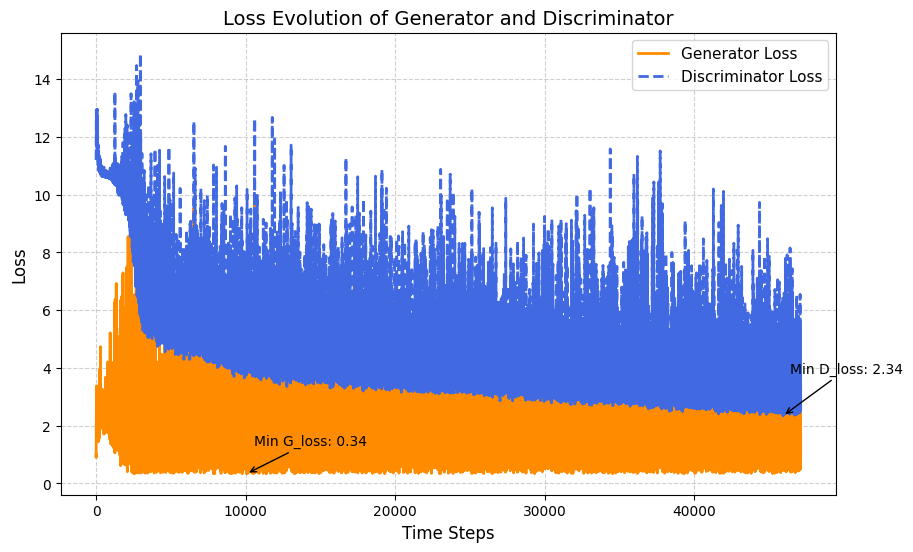

In [ ]:
# Assuming G_loss and D_loss are defined
ng = len(G_loss)
nd = len(D_loss)
time_steps_g = [i for i in range(ng)]
time_steps_d = [i for i in range(nd)]


plt.figure(figsize=(10, 6))

# Plot Generator Loss
plt.plot(time_steps_g, G_loss, label='Generator Loss', color='darkorange', linestyle='-', linewidth=2)

# Plot Discriminator Loss
plt.plot(time_steps_d, D_loss, label='Discriminator Loss', color='royalblue', linestyle='--', linewidth=2)

# Add grid, labels, and title
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss Evolution of Generator and Discriminator', fontsize=14)

# Adding legend
plt.legend(loc='upper right', fontsize=11)

# Adding annotations for minimum loss points (optional)
min_G_loss = min(G_loss)
min_G_loss_idx = G_loss.index(min_G_loss)
plt.annotate(f'Min G_loss: {min_G_loss:.2f}', xy=(min_G_loss_idx, min_G_loss),
             xytext=(min_G_loss_idx + n*0.1, min_G_loss + max(G_loss)*0.1),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10)

min_D_loss = min(D_loss)
min_D_loss_idx = D_loss.index(min_D_loss)
plt.annotate(f'Min D_loss: {min_D_loss:.2f}', xy=(min_D_loss_idx, min_D_loss),
             xytext=(min_D_loss_idx + n*0.1, min_D_loss + max(D_loss)*0.1),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10)

# Show plot
plt.show()

<strong> Plotting FID values <strong>

Text(0.5, 1.0, 'FID Evolution through training')

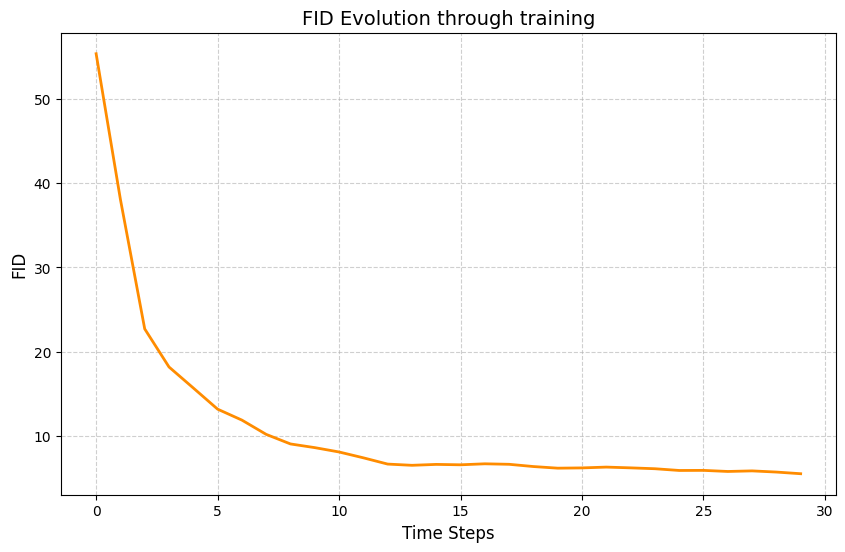

In [46]:
n = len(FID_values)
time_steps = [i for i in range(n)]

plt.figure(figsize=(10, 6))

# Plot FID values
plt.plot(time_steps, FID_values, label='Generator FID', color='darkorange', linestyle='-', linewidth=2)


# Add grid, labels, and title
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('FID', fontsize=12)
plt.title('FID Evolution through training', fontsize=14)